### Modified self-adjusted mixture sampling

Testing an extension of Z. Tan's self-adjusted mixture sampling (SAMS) from [1] where the target distributions are adapted on the fly as part of the recursion strategy to allow sampling from target distributions $\pi_j$ that depend on $\zeta_1^*, \ldots, \zeta_m^*$.

Original SAMS from [1]:
* Sample $x \sim p(x | j) \propto q_j(x)$
* Sample $j \sim p(j | x) \propto \pi_j e^{-\zeta_j} q_j(x)$
* Update $\zeta^{(t-1/2)}_j = \zeta^{(t-1)}_j - t^{-1} w_j(x; \zeta^{(t-1)})$ (Eq. 12 of [1])
and $\zeta^{(t)}_j = \zeta^{(t-1/2)}_j - \zeta^{(t-1/2)}_1$.

Modified dual-chain SAMS with extra recursion step:
* Sample $x_1 \sim p_1(x_1 | j_1) \propto q_{1,j}(x)$
* Sample $x_2 \sim p_2(x_2 | j_2) \propto q_{2,j}(x)$
* Sample $j_1 \sim p_1(j_1 | x_1) \propto \pi_{1,j_1} e^{-\zeta_{1,j_1}} q_{1,j_1}(x_1)$
* Sample $j_2 \sim p_2(j_2 | x_2) \propto \pi_{2,j_2} e^{-\zeta_{2,j_2}} q_{2,j_2}(x_2)$
* Update $\zeta^{(t-1/2)}_{1,j_1} = \zeta^{(t-1)}_{1,j} - t^{-1} w_{1,j}(x_1; \zeta_1^{(t-1)})$ (Eq. 12 of [1])
and $\zeta^{(t)}_{1,j_1} = \zeta^{(t-1/2)}_{1,j_1} - \zeta^{(t-1/2)}_{1,1}$.
* Update $\zeta^{(t-1/2)}_{2,j_2} = \zeta^{(t-1)}_{2,j} - t^{-1} w_{2,j}(x_2; \zeta_2^{(t-1)})$ (Eq. 12 of [1])
and $\zeta^{(t)}_{2,j_2} = \zeta^{(t-1/2)}_{2,j_2} - \zeta^{(t-1/2)}_{2,1}$.
* Update $\pi_{1,j_1}^{(t)} \propto f_{1,j_1}(\zeta^{(t)}_1, \zeta^{(t)}_2)$ and $\pi_{2,j_2}^{(t)} \propto f_{2,j_2}(\zeta^{(t)}_1, \zeta^{(t)}_2)$ to allow for more complex designs.

### Example

The example considered here uses the dual-chain version, with definitions
* $q_{1,j_1}(x) = \exp[-(j_1)^2 x^2 / 2]$, $j_1 = 1,\ldots,m$
* $q_{2,j_2}(x) = \exp[-(m - j_1 + 1)^2 x^2 / 2]$, $j_2 = 1, \ldots, m$
* $f_{1,j}(\zeta^{(t)}_1, \zeta^{(t)}_2) = f_{2,j}(\zeta^{(t)}_1, \zeta^{(t)}_2) \propto e^{-\zeta_{1,j} + \zeta_{2,j}}$ to achieve $\pi_{1,j} = \pi_{2,j} \propto e^{-\zeta^*_{1,j} + \zeta^*_{2,j}}$

### References
[1] Tan Z. Optimally adjusted mixture sampling and locally weighted histogram analysis. http://www.stat.rutgers.edu/home/ztan/Publication/SAMS_redo4.pdf

In [1]:
%pylab inline
import numpy as np
beta = 1.0 # inverse temperature

nstates = 6 # set number of states (m in Z. Tan paper)

K1 = np.array([ ((i+1)**2) for i in range(nstates) ])
K2 = np.array([ ((nstates-i)**2) for i in range(nstates) ])

def Z(K):
    sigma = 1.0 / np.sqrt(beta*K)
    return np.sqrt(2*np.pi)*sigma

def sample_configuration(K):
    sigma = 1.0 / np.sqrt(beta*K)
    return sigma * np.random.normal()

def u(x, K):
    return (beta*K)/2 * x**2

Populating the interactive namespace from numpy and matplotlib


In [2]:
# compute optimal probabilities pi_k_star
zeta1_star = np.log(Z(K1)); zeta1_star -= zeta1_star[0]
zeta2_star = np.log(Z(K2)); zeta2_star -= zeta2_star[0]
pi_k_star = np.exp(-zeta1_star + zeta2_star)
pi_k_star /= pi_k_star.sum()
print pi_k_star

[ 0.01494768  0.03587444  0.06726457  0.11958146  0.22421525  0.53811659]


In [3]:
def sample_state(q_k, zeta_k, pi_k):
    """
    Sample a state using Gibbs sampling.
    
    Parameters
    ----------
    x : float
        Fixed configuration
    """
    P_k = pi_k * np.exp(-zeta_k) * q_k
    P_k /= P_k.sum()
    k = np.random.choice(nstates, p=P_k)
    return [P_k,k]

T = 1000 # number of samples

# Initial conditions
x1 = 0; x1 = 0
k1 = 0; k2 = 0
zeta1_k = np.zeros([nstates], np.float64); zeta2_k = np.zeros([nstates], np.float64)
pi1_k = np.ones([nstates], np.float64); pi2_k = np.ones([nstates], np.float64)

zeta1_tk = np.zeros([T,nstates], np.float32); zeta2_tk = np.zeros([T,nstates], np.float32)
x1_t = np.zeros([T], np.float32); x2_t = np.zeros([T], np.float32)
k1_t = np.zeros([T], np.int32); k2_t = np.zeros([T], np.int32)
pi_tk = np.zeros([T,nstates], np.float32)
for t in range(T):
    # Update sampled conformations.
    x1 = sample_configuration(K1[k1])
    x2 = sample_configuration(K2[k2])

    # Update state index k.
    [P1_k, k1] = sample_state(np.exp(-u(x1,K1)), zeta1_k, pi1_k)
    [P2_k, k2] = sample_state(np.exp(-u(x2,K2)), zeta2_k, pi2_k)
    
    # Adapt weights.
    zeta1_k += 1.0/(t+1.) * P1_k/pi1_k; zeta1_k -= zeta1_k[0]
    zeta2_k += 1.0/(t+1.) * P2_k/pi2_k; zeta2_k -= zeta2_k[0]
    
    # Adapt target probabilities using current estimates of zeta_star.
    pi_k = np.exp(-zeta1_k+zeta2_k)
    pi_k /= pi_k.sum()
    pi1_k = pi_k; pi2_k = pi_k
    
    # Store history.
    x1_t[t] = x1; x2_t[t] = x2
    k1_t[t] = k1; k2_t[t] = k2
    pi_tk[t,:] = pi_k
    zeta1_tk[t,:] = zeta1_k; zeta2_tk[t,:] = zeta2_k    

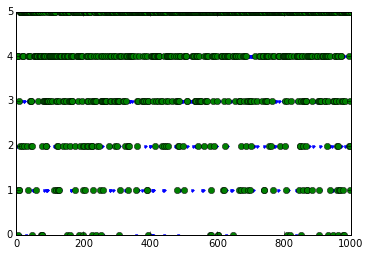

In [4]:
import pylab
pylab.plot(k1_t, '.', k2_t, 'o');

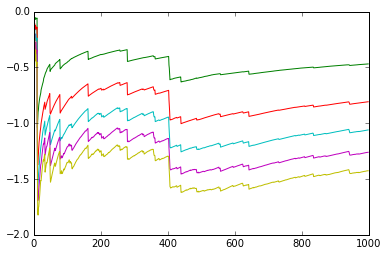

In [5]:
plot(zeta1_tk);

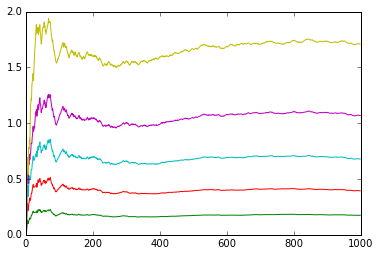

In [6]:
plot(zeta2_tk)

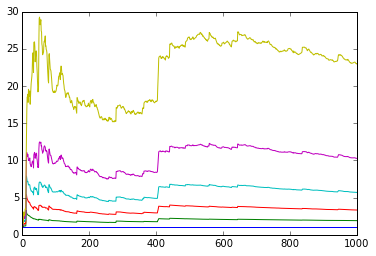

In [7]:
plot(np.exp(-zeta1_tk + zeta2_tk));

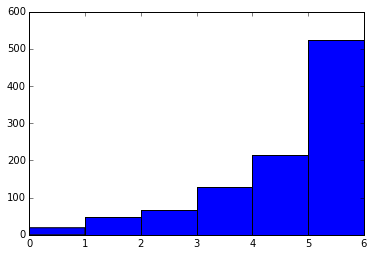

In [8]:
pylab.hist(k1_t, arange(nstates+1));

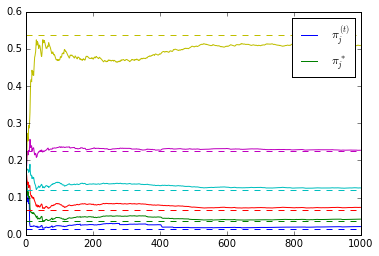

In [9]:
plot(arange(0,T), pi_tk, '-');
hold(True)
plt.gca().set_color_cycle(None)
plot([0, T], [pi_k_star, pi_k_star], '--');
legend(['$\pi_j^{(t)}$', '$\pi_j^*$']);

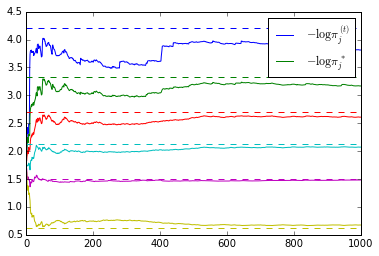

In [10]:
plot(arange(0,T), -np.log(pi_tk), '-');
hold(True)
plt.gca().set_color_cycle(None)
plot([0, T], [-np.log(pi_k_star), -np.log(pi_k_star)], '--');
legend(['$-\log \pi_j^{(t)}$', '$-\log \pi_j^*$']);